<a href="https://colab.research.google.com/github/ganesh75690/garbage-aicte/blob/main/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
from google.colab import files
from zipfile import ZipFile

# Upload your dataset ZIP file
uploaded = files.upload()


Saving garbage.zip to garbage.zip


In [3]:
with ZipFile("garbage.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [4]:
dataset_dir= r"D:\garbage\Multi class garbage classification\test"
image_size = (128, 128)
batch_size = 32
seed = 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/Multi class garbage classification/test",   # dataset_dir
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

Found 285 files belonging to 7 classes.
Using 228 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/Multi class garbage classification/test",    # dataset_dir
    validation_split=0.2,
    subset="validation",
    seed=123,                      # seed
    shuffle=True,
    image_size=(128, 128),        # image_size
    batch_size=32                 # batch_size
)

val_class = val_ds.class_names
print("Validation Classes:", val_class)

Found 285 files belonging to 7 classes.
Using 57 files for validation.
Validation Classes: ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
7


In [9]:
import matplotlib.pyplot as plt

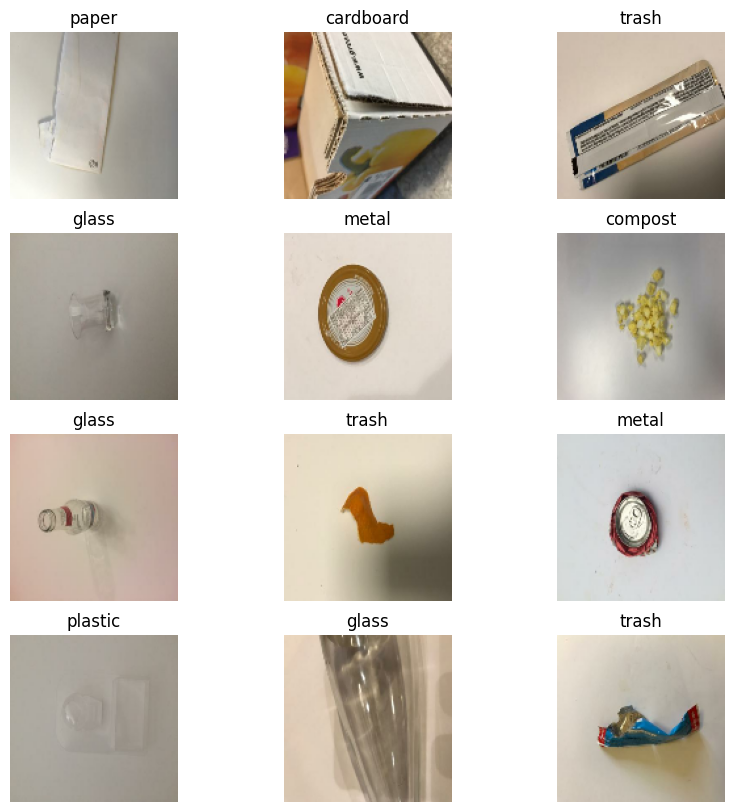

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")